In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [3]:
df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [4]:
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

# Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

**1. Crosstab Analysis:**

- Create a crosstab between the product category and the isBestSeller status.

- Are there categories where being a best-seller is more prevalent?

- _Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order._

In [5]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [6]:
crosstab_result.sort_values(by=[True], ascending=False)

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Printer Accessories,254,0
Projectors,8698,0
Bedding Collections,6309,0


It's more prevalent to be best seller in the categories "Grocery" and "Health & Personal Care".

**2. Statistical Tests:**

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [7]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

Both categories are not independent...

In [8]:
from scipy.stats.contingency import association

association(crosstab_result, method="cramer")

0.1222829439760564

...however, they don't have a strong association.

**3. Visualizations:**

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

<Axes: xlabel='category'>

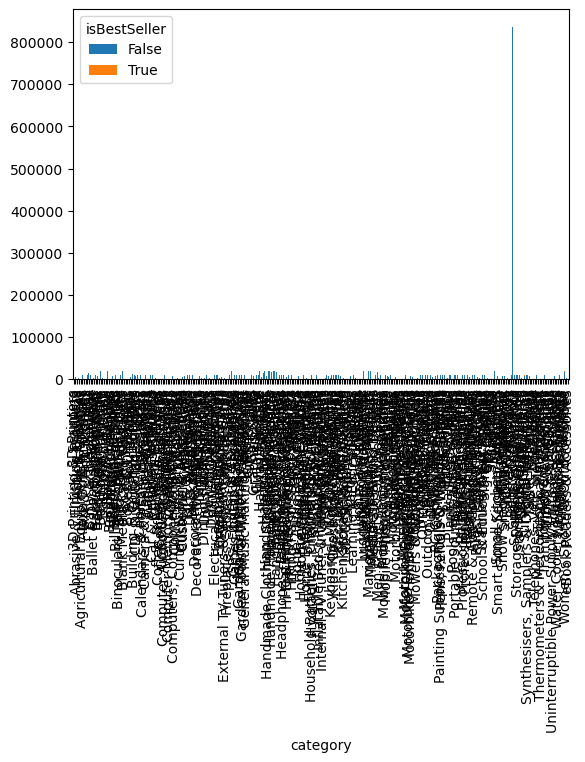

In [9]:
crosstab_result.plot(kind="bar", stacked=True)

Given the amount of categories, a stacked bar chart including all the data is not viable. I will use the top 10 categories where best-sellers are more prevalent, excepting Sports & Outdoors since it's an outlier.

<Axes: xlabel='category'>

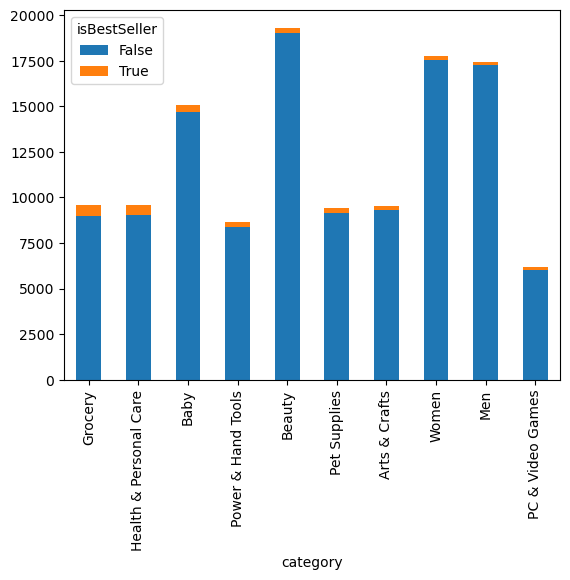

In [10]:
crosstab_result[crosstab_result.index != "Sports & Outdoors"].sort_values(by=[True], ascending=False)[:10].plot(kind="bar", stacked=True)

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

**0. Preliminary Step: Remove outliers in product prices.** 

- For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

- Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [11]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

In [12]:
outliers = tukeys_test_outliers(df["price"])

In [13]:
outliers.sort_values(ascending=False)

2008013    100000.00
1987238     77752.00
1905315     24674.59
1408966     23482.73
319555      22933.42
             ...    
827459        100.00
1592120       100.00
566914        100.00
565831        100.00
1574850       100.00
Name: price, Length: 327688, dtype: float64

In [14]:
df_no_outliers = df[df["price"] < 100]

**1. Violin Plots:**

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.

In [15]:
df_no_outliers_top20categories = df_no_outliers[df_no_outliers["category"].isin(df_no_outliers["category"].value_counts().sort_values(ascending=False)[:20].index)]

/var/folders/3j/f7d6p9t136x34vdmdy30wrrc0000gn/T/ipykernel_5759/21267092.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_no_outliers_top20categories, x='category', y='price', palette="coolwarm")


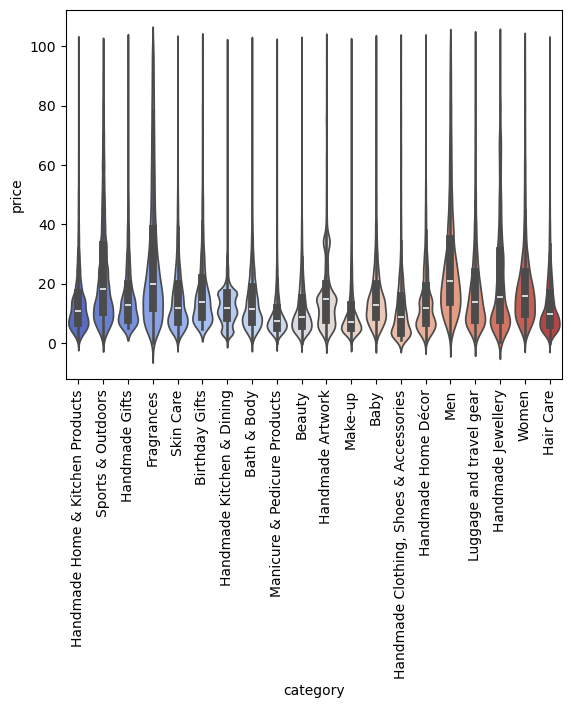

In [16]:
sns.violinplot(data=df_no_outliers_top20categories, x='category', y='price', palette="coolwarm")
plt.xticks(rotation=90)
plt.show();

**2. Bar Charts:**

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
- Which product category commands the highest average price? Don't filter here by top categories.

In [39]:
df_no_outliers_top10categories = df_no_outliers[df_no_outliers["category"]
        .isin(df_no_outliers["category"]
        .value_counts()
        .sort_values(ascending=False)[:10]
        .index)]

In [31]:
top10_avg_prices = df_no_outliers_top10categories.groupby("category")["price"].mean().round(2)
top10_avg_prices_df = pd.DataFrame(top10_avg_prices)
top10_avg_prices_df

,price
category,
Bath & Body,14.68
Beauty,12.52
Birthday Gifts,18.60
Hair Care,13.46
"Handmade Clothing, Shoes & Accessories",12.96
Handmade Gifts,17.40
Make-up,10.61
Manicure & Pedicure Products,10.23
Skin Care,15.65


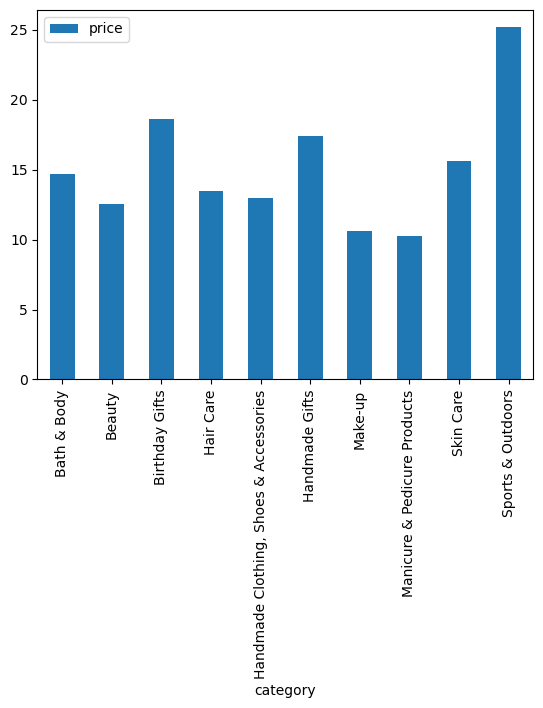

In [36]:
top10_avg_prices_df.plot(kind="bar")
plt.xticks(rotation=90)
plt.show();

The product category with the highest average price is Sports & Outdoors.

**3. Box Plots:**

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [45]:
# Filter out 0.0 ratings
df_no_outliers_top10categories_validratings = df_no_outliers_top10categories[df_no_outliers_top10categories["stars"] > 0.0]

/var/folders/3j/f7d6p9t136x34vdmdy30wrrc0000gn/T/ipykernel_5759/3655970435.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers_top10categories_validratings, x='category', y='stars', palette="coolwarm")


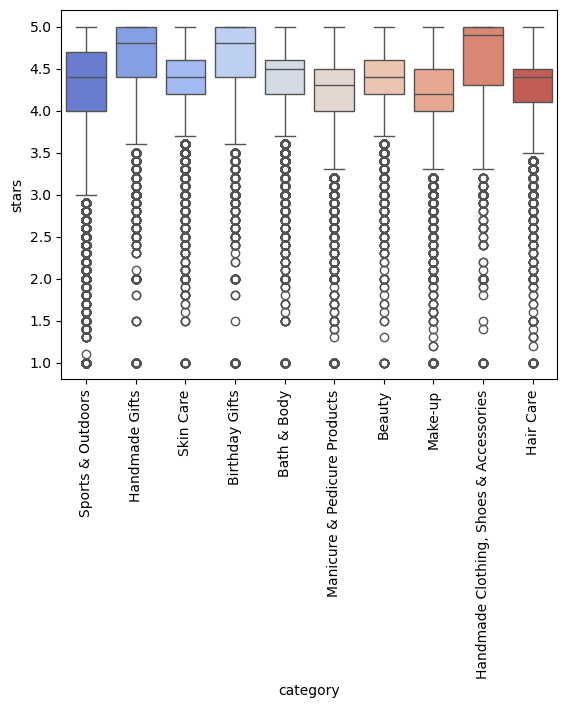

In [49]:
sns.boxplot(data=df_no_outliers_top10categories_validratings, x='category', y='stars', palette="coolwarm")
plt.xticks(rotation=90)
plt.show();

# Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

**1. Correlation Coefficients:**

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?

In [52]:
#Checking only with valid ratings
df_no_outliers_valid_ratings = df_no_outliers[df_no_outliers["stars"] > 0.0]
correlation = df_no_outliers_valid_ratings['price'].corr(df['stars'])
correlation

0.006744508067157991

In [53]:
correlation = df_no_outliers_valid_ratings['price'].corr(df['stars'], method='spearman')
correlation

0.02465961720538042

Very low correlation coefficient.

**2. Visualizations:**

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
- Use a correlation heatmap to visualize correlations between all numerical variables.
- Examine if product prices typically follow a normal distribution using a QQ plot.

<Axes: xlabel='price', ylabel='stars'>

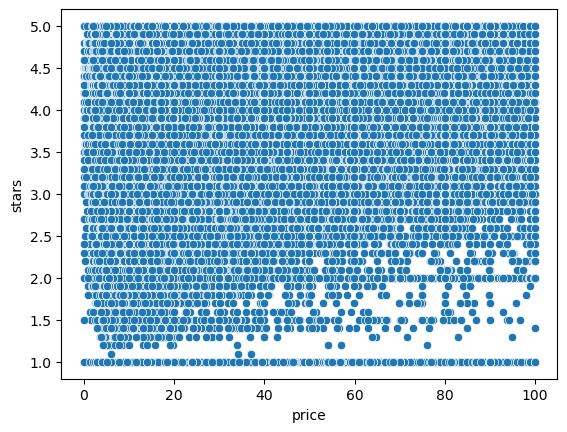

In [55]:
sns.scatterplot(data=df_no_outliers_valid_ratings, x='price', y='stars')

In [59]:
correlation_matrix = df_no_outliers_valid_ratings.select_dtypes(include="number").corr()

<Axes: >

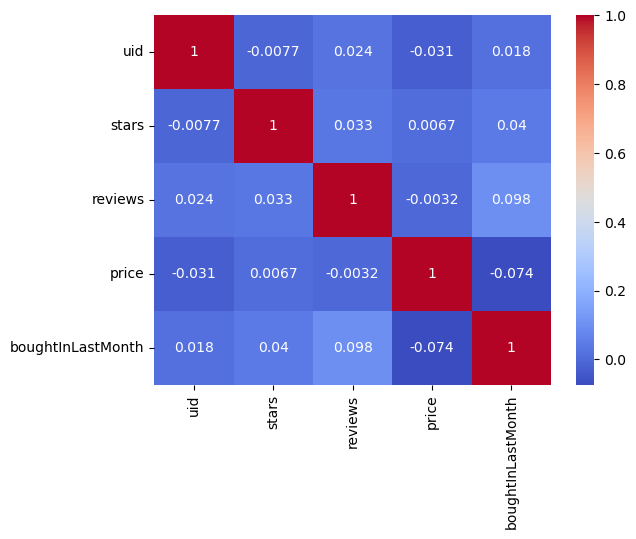

In [60]:
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

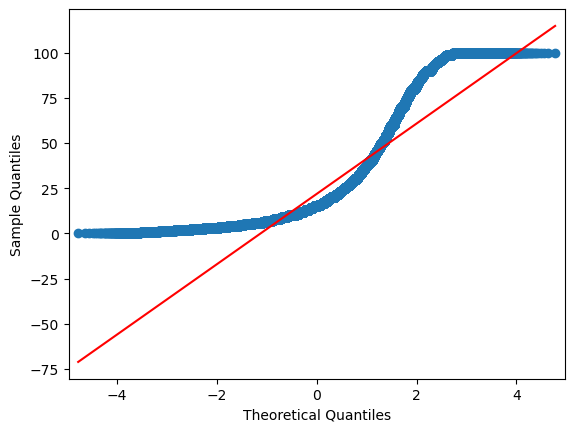

In [61]:
import statsmodels.api as sm

sm.qqplot(df_no_outliers_valid_ratings['price'], line='s');